##Системы искусственного интеллекта

##ЛР5. Ансамбли, случайный лес, градиентный бустинг
[20 + 2 баллов]

Чураков А. А. P3331 409856

--------

Начнём с датасета, который представляет собой данные о подержанных автомобилях, продаваемых в Великобритании. Он включает в себя характеристики автомобилей (пробег, год выпуска, тип двигателя и т. п.) и их цену (целевая переменная)

[Описание датасета на kaggle](https://www.kaggle.com/datasets/muhammadawaistayyab/used-cars-prices-in-uk)

Прежде чем начать, импортируем некоторые модули и загрузим данные

In [ ]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [ ]:
! gdown 1Cdek-lsS3-XiDFtD5PzgXNsy3gvd_Rd-

Downloading...
From: https://drive.google.com/uc?id=1Cdek-lsS3-XiDFtD5PzgXNsy3gvd_Rd-
To: /content/used_cars_UK.csv
100% 290k/290k [00:00<00:00, 138MB/s]


##  <font color='DarkOrange'>**Задача 1 [1 балл]**</font>

Подготовка данных

Считайте датасет и предобработайте его:
1. Удалите ненужные столбцы: `'Unnamed: 0'`, `'Service history'`, `'title'`
2. Заполните пропуски в вещественных переменных. Пустые значения в поле `Previous Owners` заполните `0`, остальные поля заполните `средними значениями`
3. Обработайте `категориальные переменные:` объедините редкие классы в `"Other"`, после этого преобразуйте `категориальные переменные` в вещественные с помощью [pd.get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) или [One-Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
    * Обратите внимание на поле `Engine`. Чем оно отличается от `Fuel type` или `Body type`?
4. Разбейте весь датасет на `train/test` в пропорции `80/20`, зафиксируйте `random_state=42`
    * Для `X_train`, `X_test`, `y_train`, `y_test` обновите индексы через `df.reset_index(drop=True)`

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/used_cars_UK.csv")

drop_cols = ['Unnamed: 0', 'Service history', 'title']
df = df.drop(columns=drop_cols, errors='ignore')

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

if 'Previous Owners' in df.columns:
    df['Previous Owners'] = df['Previous Owners'].fillna(0)

for col in num_cols:
    if col != 'Previous Owners':
        df[col] = df[col].fillna(df[col].mean())

cat_cols = df.select_dtypes(include=['object']).columns.tolist()

def collapse_rare(series, threshold=0.01):
    freq = series.value_counts(normalize=True)
    rare_values = freq[freq < threshold].index
    return series.replace(rare_values, "Other")

for col in cat_cols:
    df[col] = collapse_rare(df[col])

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

if 'Engine' in df.columns:
    df['Engine'] = df['Engine'].astype(str).str.extract(r'(\d\.\d+)').astype(float)

y = df['Price']
X = df.drop(columns=['Price'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

X_train.head()


,Mileage(miles),Registration_Year,Previous Owners,Doors,Seats,Fuel type_Other,Fuel type_Petrol,Fuel type_Petrol Hybrid,Body type_Coupe,Body type_Estate,...,Engine_2.0L,Engine_2.1L,Engine_2.2L,Engine_3.0L,Engine_Other,Gearbox_Manual,Emission Class_Euro 4,Emission Class_Euro 5,Emission Class_Euro 6,Emission Class_Other
0,55301,2016,0.0,5.0,5.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
1,49482,2017,2.0,5.0,5.0,False,True,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,122000,2010,5.0,5.0,5.0,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
3,111695,2011,3.0,5.0,5.0,False,True,False,False,False,...,False,False,False,False,False,True,True,False,False,False
4,124000,2009,0.0,3.0,5.0,False,True,False,False,False,...,False,False,False,False,False,True,True,False,False,False


 ## <font color='DarkOrange'>**Задача 2 [3 балла]**</font>

Постройте бэггинг над решающими деревьями

Постройте бэггинг с решающими деревьями для задачи регрессии

Используйте [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) из sklearn, параметры по умолчанию, зафиксировав `random_state=42`, обучите ансамбль, на тесте посмотрите метрики RMSE и MAPE

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # в %

print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 1780.916
MAPE: 23.88%


Подберите оптимальные гиперпараметры с помощью [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) для бэггинга

"Пробегитесь" по следующим параметрам:
* `n_estimators: [10, 25, 50, 100, 200]`
* `max_features: [0.2, 0.5, 0.7, 1.0]`
* `max_samples: [0.5, 0.75, 1.0]`
* `base_estimator__max_depth: [4, 6, 8, 10, 20, None]` — этот параметр оптимизирует глубину базового алгоритма (дерева)

В качестве метрики оптимизации для GridSearchCV используйте `MSE` (при инициализации `GridSearchCV()` будет `scoring='neg_mean_squared_error'`)

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

param_grid = {
    "n_estimators": [10, 25, 50, 100, 200],
    "max_features": [0.2, 0.5, 0.7, 1.0],
    "max_samples": [0.5, 0.75, 1.0],
    "estimator__max_depth": [4, 6, 8, 10, 20, None]
}

grid = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=2,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Лучшие параметры:")
print(grid.best_params_)

print("\nЛучшее значение MSE (со знаком минус):")
print(grid.best_score_)

Fitting 2 folds for each of 360 candidates, totalling 720 fits
Лучшие параметры:
{'estimator__max_depth': 10, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 50}

Лучшее значение MSE (со знаком минус):
-2281295.9929918707


Обучите модель с лучшими параметрами и оцените на тесте.
Насколько улучшилось качество модели по сравнению с моделью с параметрами по умолчанию?

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

default_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    random_state=42
)

default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)

rmse_default = np.sqrt(mean_squared_error(y_test, y_pred_default))
mape_default = mean_absolute_percentage_error(y_test, y_pred_default) * 100

print("=== Default model ===")
print(f"RMSE: {rmse_default:.3f}")
print(f"MAPE: {mape_default:.2f}%")


=== Default model ===
RMSE: 1780.916
MAPE: 23.88%


In [ ]:
best_model = grid.best_estimator_

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mape_best = mean_absolute_percentage_error(y_test, y_pred_best) * 100

print("\n=== Best model ===")
print(f"RMSE: {rmse_best:.3f}")
print(f"MAPE: {mape_best:.2f}%")


=== Best model ===
RMSE: 1805.986
MAPE: 26.49%


In [ ]:
print("\n=== Improvement ===")
print(f"RMSE improvement: {rmse_default - rmse_best:.3f}")
print(f"MAPE improvement: {mape_default - mape_best:.2f}%")


=== Improvement ===
RMSE improvement: -25.070
MAPE improvement: -2.61%


## <font color='DarkOrange'>**Задача 3 [3 баллa]**</font>  

Блендинг (вспомните, какое требуется условие на коэффициенты линейной модели как мета-алгоритма)

Постройте 3 базовые модели
* линейная регрессия,
* kNN (k > 1),
* дерево решений (зафиксируйте random_state=42)

Проверьте модели:

* Обучите модели на всём обучающем датасете.
* Оцените качество моделей `(RMSE / MAPE)` на тесте

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

lin = LinearRegression()
lin.fit(X_train, y_train)

y_pred_lin = lin.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin) * 100

print("=== Linear Regression ===")
print(f"RMSE: {rmse_lin:.3f}")
print(f"MAPE: {mape_lin:.2f}%")

=== Linear Regression ===
RMSE: 2314.459
MAPE: 36.86%


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn) * 100

print("\n=== kNN (k=5) ===")
print(f"RMSE: {rmse_knn:.3f}")
print(f"MAPE: {mape_knn:.2f}%")


=== kNN (k=5) ===
RMSE: 3183.561
MAPE: 51.19%


In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
mape_tree = mean_absolute_percentage_error(y_test, y_pred_tree) * 100

print("\n=== Decision Tree ===")
print(f"RMSE: {rmse_tree:.3f}")
print(f"MAPE: {mape_tree:.2f}%")


=== Decision Tree ===
RMSE: 2162.595
MAPE: 32.18%


Разделите обучающий датасет на 2 подвыборки в соотношении 80/20: одна будет использована для обучения базовой модели `(X_base_train, y_base_train)`, другая для <font color='CornflowerBlue'>**мета-модели**</font> `(X_meta_train, y_meta_train)`

In [ ]:
from sklearn.model_selection import train_test_split

X_base_train, X_meta_train, y_base_train, y_meta_train = train_test_split(
    X_train,            # уже существующий train после первого split
    y_train,
    test_size=0.2,      # 20% на мета-модель
    random_state=42
)

X_base_train = X_base_train.reset_index(drop=True)
X_meta_train = X_meta_train.reset_index(drop=True)
y_base_train = y_base_train.reset_index(drop=True)
y_meta_train = y_meta_train.reset_index(drop=True)

X_base_train.shape, X_meta_train.shape

((2358, 32), (590, 32))

Обучите блендинг и оцените его качество
1. Обучите базовые модели на `X_base_train`
2. Сделайте предсказания базовых моделей на `X_meta_trai`n. Объедините все предсказания в один `DataFrame`, замените исходный `X_meta_train` на полученный `df` из прогнозов базовых моделей
3. Обучите мета-модель — `линейную регрессию` на обновлённом `X_meta_train`
4. Сделайте прогнозы базовых моделей на `X_test`. Объедините все прогнозы в один `DataFrame` — `X_meta_test`
5. Сделайте прогноз мета-модели на `X_meta_test`, оцените качество полученной модели с помощью `y_test`
<font color='LightSteelBlue'>**Подсказка.**</font> Воспользуйтесь любым готовым решением для блендинга

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Базовые модели
m1 = LinearRegression()
m2 = KNeighborsRegressor(n_neighbors=5)
m3 = DecisionTreeRegressor(random_state=42)

# Обучение на base-подвыборке
m1.fit(X_base_train, y_base_train)
m2.fit(X_base_train, y_base_train)
m3.fit(X_base_train, y_base_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
import pandas as pd

meta_features = pd.DataFrame({
    "linreg": m1.predict(X_meta_train),
    "knn":    m2.predict(X_meta_train),
    "tree":   m3.predict(X_meta_train)
})

y_meta = y_meta_train

In [ ]:
meta_model = LinearRegression()
meta_model.fit(meta_features, y_meta)

LinearRegression()

In [ ]:
X_meta_test = pd.DataFrame({
    "linreg": m1.predict(X_test),
    "knn":    m2.predict(X_test),
    "tree":   m3.predict(X_test)
})

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

y_pred_blend = meta_model.predict(X_meta_test)

rmse_blend = np.sqrt(mean_squared_error(y_test, y_pred_blend))
mape_blend = mean_absolute_percentage_error(y_test, y_pred_blend) * 100

print(f"Blending RMSE: {rmse_blend:.3f}")
print(f"Blending MAPE: {mape_blend:.2f}%")

Blending RMSE: 1995.725
Blending MAPE: 30.69%


Оцените качество итоговой модели.
Сравните её с базовыми моделями и с бэггингом над решающими деревьями

In [ ]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "kNN",
        "Decision Tree",
        "Bagging (default)",
        "Bagging (best params)",
        "Blending"
    ],
    "RMSE": [
        rmse_lin,
        rmse_knn,
        rmse_tree,
        rmse_default,   # исправлено
        rmse_best,      # исправлено
        rmse_blend
    ],
    "MAPE": [
        mape_lin,
        mape_knn,
        mape_tree,
        mape_default,   # исправлено
        mape_best,      # исправлено
        mape_blend
    ]
})

print(results)


                   Model         RMSE       MAPE
0      Linear Regression  2314.458938  36.856637
1                    kNN  3183.561274  51.193871
2          Decision Tree  2162.594881  32.179643
3      Bagging (default)  1780.916142  23.880592
4  Bagging (best params)  1805.986010  26.486536
5               Blending  1995.724918  30.692696


## <font color='DarkOrange'>**Задача 4 [3 баллa]**</font> + <font color='MediumSeaGreen'>**[2 бонусных балла]**</font>

Стекинг - усложняем мета-алгоритм

Обучите стекинг
1. Воспользуйтесь готовым классом [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html) из sklearn
2. В качестве базовых моделей инициализируйте `линейную регрессию, kNN, решающее дерево`
3. В качестве мета-модели (`final_estimator`) используйте `линейную регрессию`
4. Обучите построенную модель на `X_train`, сделайте прогнозы на `X_test`

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

estimators = [
    ('linreg', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('tree', DecisionTreeRegressor(random_state=42))
]

final_estimator = LinearRegression()

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    n_jobs=-1
)

stack_model.fit(X_train, y_train)

y_pred_stack = stack_model.predict(X_test)

rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
mape_stack = mean_absolute_percentage_error(y_test, y_pred_stack) * 100

print(f"Stacking RMSE: {rmse_stack:.3f}")
print(f"Stacking MAPE: {mape_stack:.2f}%")

Stacking RMSE: 1986.400
Stacking MAPE: 30.40%


Оцените качество полученной модели.
Сравните его с базовыми моделями, с бэггингом над решающими деревьями и с блендингом по RMSE и MAPE

In [ ]:
results = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "kNN",
        "Decision Tree",
        "Bagging (default)",
        "Bagging (best params)",
        "Blending",
        "Stacking"
    ],
    "RMSE": [
        rmse_lin,
        rmse_knn,
        rmse_tree,
        rmse_default,
        rmse_best,
        rmse_blend,
        rmse_stack
    ],
    "MAPE": [
        mape_lin,
        mape_knn,
        mape_tree,
        mape_default,
        mape_best,
        mape_blend,
        mape_stack
    ]
})

print("\n=== Comparison table ===")
print(results)


=== Comparison table ===
                   Model         RMSE       MAPE
0      Linear Regression  2314.458938  36.856637
1                    kNN  3183.561274  51.193871
2          Decision Tree  2162.594881  32.179643
3      Bagging (default)  1780.916142  23.880592
4  Bagging (best params)  1805.986010  26.486536
5               Blending  1995.724918  30.692696
6               Stacking  1986.399956  30.403073


<font color='MediumOrchid'>**Ваши выводы тут:**</font>

По итогам экспериментов видно, что базовые модели (линейная регрессия, kNN и дерево решений) показывают относительно невысокое качество, причём наилучший результат среди них демонстрирует дерево решений (RMSE ≈ 2162, MAPE ≈ 32%).

Бэггинг над решающими деревьями значительно улучшает качество: модель по умолчанию даёт наилучший результат среди всех подходов (RMSE ≈ 1781, MAPE ≈ 23.88%). Интересно, что подбор гиперпараметров не дал дальнейшего улучшения — напротив, качество немного ухудшилось, что может указывать на переобучение или на то, что параметры по умолчанию уже достаточно хорошо подходят под структуру данных.

Блендинг, объединяющий предсказания базовых моделей, улучшает качество по сравнению с линейной регрессией и kNN, но остаётся слабее бэггинга (RMSE ≈ 1996, MAPE ≈ 30.7%).

Стекинг показывает чуть лучший результат, чем блендинг (RMSE ≈ 1986, MAPE ≈ 30.4%), благодаря более корректной схеме обучения мета-модели. Однако он всё равно уступает бэггингу, который остаётся лидером по качеству.

Таким образом, наилучшей моделью в задаче является BaggingRegressor с параметрами по умолчанию, обеспечивающий минимальные ошибки RMSE и MAPE.

Добавьте в список базовых моделей бэггинг, полученный ранее.
Обучите новую модель и оцените её качество

In [ ]:
from sklearn.ensemble import StackingRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

bag_base = grid.best_estimator_

estimators = [
    ('linreg', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('tree', DecisionTreeRegressor(random_state=42)),
    ('bagging', bag_base)
]

final_estimator = LinearRegression()

stack_plus = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

stack_plus.fit(X_train, y_train)

y_pred_stack_plus = stack_plus.predict(X_test)

rmse_stack_plus = np.sqrt(mean_squared_error(y_test, y_pred_stack_plus))
mape_stack_plus = mean_absolute_percentage_error(y_test, y_pred_stack_plus) * 100

print("=== Stacking + Bagging as base model ===")
print(f"RMSE: {rmse_stack_plus:.3f}")
print(f"MAPE: {mape_stack_plus:.2f}%")

=== Stacking + Bagging as base model ===
RMSE: 1782.399
MAPE: 24.96%


Попробуйте подобрать гиперпараметры для решающего дерева с помощью `GridSearchCV`

Оптимизируйте `max_depth`, `min_samples_split`, `max_features` на всём `X_train`

Получилось ли вырасти в качестве отдельной для решающего дерева? А на всём стекинге?

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid_tree = {
    "max_depth": [4, 6, 8, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10, 20],
    "max_features": ["sqrt", "log2", None]
}

grid_tree = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_tree,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_tree.fit(X_train, y_train)

print("Лучшие параметры дерева:", grid_tree.best_params_)

Fitting 3 folds for each of 84 candidates, totalling 252 fits
Лучшие параметры дерева: {'max_depth': 10, 'max_features': None, 'min_samples_split': 20}


In [ ]:
best_tree = grid_tree.best_estimator_

y_pred_tree_best = best_tree.predict(X_test)

rmse_tree_best = np.sqrt(mean_squared_error(y_test, y_pred_tree_best))
mape_tree_best = mean_absolute_percentage_error(y_test, y_pred_tree_best) * 100

print("=== Improved Decision Tree ===")
print(f"RMSE: {rmse_tree_best:.3f}")
print(f"MAPE: {mape_tree_best:.2f}%")

=== Improved Decision Tree ===
RMSE: 1968.835
MAPE: 28.74%


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

estimators = [
    ('linreg', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('tree_best', best_tree),             # ← добавляем улучшенное дерево
]

stack_model_best_tree = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

stack_model_best_tree.fit(X_train, y_train)
y_pred_stack_best_tree = stack_model_best_tree.predict(X_test)

rmse_stack_best_tree = np.sqrt(mean_squared_error(y_test, y_pred_stack_best_tree))
mape_stack_best_tree = mean_absolute_percentage_error(y_test, y_pred_stack_best_tree) * 100

print("\n=== Stacking with improved Decision Tree ===")
print(f"RMSE: {rmse_stack_best_tree:.3f}")
print(f"MAPE: {mape_stack_best_tree:.2f}%")


=== Stacking with improved Decision Tree ===
RMSE: 1918.444
MAPE: 28.18%


<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Подбор гиперпараметров позволил значительно улучшить качество отдельного решающего дерева: RMSE снизился с 2162.6 → 1968.8, а MAPE — с 32.18% → 28.74%. Это ожидаемый результат: оптимизация глубины, минимального числа объектов в узле и числа признаков уменьшает переобучение и делает дерево более устойчивым.

Добавление улучшенного дерева в стекинг также привело к росту качества. RMSE стекинга снизился с 1986.4 → 1918.4, а MAPE — с 30.40% → 28.18%. Однако улучшение оказалось умеренным, что связано с тем, что стекинг уже объединяет несколько сильных моделей, и вклад одной улучшенной модели даёт ограниченный эффект.

В целом, оптимизация дерева положительно влияет как на его собственные метрики, так и на итоговый стекинг, что подтверждает пользу подбора гиперпараметров даже в составе ансамбля.

**<font color='MediumSeaGreen'>[1 балл, бонус]</font>**
Попробуйте улучшить результат, используя другой класс мета-модели

In [ ]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

estimators = [
    ('linreg', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('tree_best', best_tree)
]

# Мета-модель — Gradient Boosting
meta_gb = GradientBoostingRegressor(random_state=42)

stack_gb = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_gb,
    n_jobs=-1
)

stack_gb.fit(X_train, y_train)
y_pred_stack_gb = stack_gb.predict(X_test)

rmse_stack_gb = np.sqrt(mean_squared_error(y_test, y_pred_stack_gb))
mape_stack_gb = mean_absolute_percentage_error(y_test, y_pred_stack_gb) * 100

print("=== Stacking with GradientBoosting meta-model ===")
print(f"RMSE: {rmse_stack_gb:.3f}")
print(f"MAPE: {mape_stack_gb:.2f}%")

=== Stacking with GradientBoosting meta-model ===
RMSE: 1814.512
MAPE: 27.18%


## <font color='DarkOrange'>**Задача 5 [5 баллов]**</font>

* Выполните собственную программую реализацию случайного леса для задачи многоклассовой классификации (используйте датасет из ЛР1,2,3)
* <font color='DarkSeaGreen'>**Можно использовать**</font> уже реализованные классы `sklearn`: `tree.DecisionTreeClassifier` и `tree.DecisionTreeRegressor`.

* <font color='OrangeRed'>**Нельзя использовать**</font> уже реализованные классы `sklearn`: классы леса, а также `ensemble.BaggingClassifier` и `ensemble.BaggingRegressor`.

* <font color='OrangeRed'>**Необходим**</font> код реализации. Без него задание засчитываться не будет



In [ ]:
!curl -L -o "$(pwd)/mobile-phone-price.zip" "https://www.kaggle.com/api/v1/datasets/download/rkiattisak/mobile-phone-price"
!unzip -o mobile-phone-price.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4821  100  4821    0     0  10347      0 --:--:-- --:--:-- --:--:-- 21331
Archive:  mobile-phone-price.zip
  inflating: Mobile phone price.csv  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline

In [ ]:
def load_and_clean_data(path: str = "Mobile phone price.csv")-> pd.DataFrame:
  df = pd.read_csv("Mobile phone price.csv").rename(columns=str.strip)

  for col in ["Storage", "RAM"]:
      df[col] = df[col].str.replace(r"[^0-9]", "", regex=True).astype(int)

  df["Battery"] = df["Battery Capacity (mAh)"].astype(str).str.replace(r"[^0-9]", "", regex=True).astype(int)
  df["Price"] = df["Price ($)"].astype(str).str.replace(r"[^0-9]", "", regex=True).astype(int)

  df["Camera"] = (
      df["Camera (MP)"]
      .astype(str)
      .str.replace(r"[^0-9\+]", "", regex=True)
      .str.split("+")
      .apply(lambda lst: sum(float(x) for x in lst if x.strip() != ""))
  )

  df["ScreenSize"] = (
      df["Screen Size (inches)"]
      .astype(str)
      .str.replace(r"[^0-9\+\.]", "", regex=True)
      .str.split("+")
      .apply(lambda lst: sum(float(x) for x in lst if x.strip() != ""))
  )

  df = df[["Brand", "Model", "Storage", "RAM", "ScreenSize", "Battery", "Camera", "Price"]]

  return df

In [ ]:
df = load_and_clean_data()

<font color='LightSteelBlue'>**Комментарии**</font>

* Выберите дефолтные значения для приведенных в классе параметров
    * <font color='DarkSeaGreen'>**Можно добавлять**</font> новые гиперпараметры, исходя из вашей задачи.
* Методы `fit`, `predict`, `predict_proba` должны <font color='OrangeRed'>**обязательно присутствовать**</font>. От них ожидается стандартный привычный функционал и вывод по аналогии с `sklearn`.
Сигнатуру методов можно упростить относительно аналогов из библиотеки (не гонимся за кол-вом параметров)

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator

class MyRandomForest(BaseEstimator):
    def __init__(
        self,
        n_estimators=100,
        max_features='sqrt',
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=None,
        bootstrap=True,
        random_state=42
    ):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.random_state = random_state

        self.trees = []
        self.feature_indices = []
        np.random.seed(self.random_state)

    def _sample_bootstrap(self, X, y):
        n = len(X)
        idx = np.random.choice(n, size=n, replace=True)
        return X[idx], y[idx]

    def _sample_features(self, X):
        n_features = X.shape[1]

        if isinstance(self.max_features, int):
            k = self.max_features
        elif self.max_features == "sqrt":
            k = int(np.sqrt(n_features))
        elif self.max_features == "log2":
            k = int(np.log2(n_features))
        else:
            k = n_features

        feat_idx = np.random.choice(n_features, size=k, replace=False)
        return feat_idx

    def fit(self, X_train, y_train):
        self.classes_ = np.unique(y_train)
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        for _ in range(self.n_estimators):
            # 1) Bootstrap sample
            if self.bootstrap:
                X_samp, y_samp = self._sample_bootstrap(X_train, y_train)
            else:
                X_samp, y_samp = X_train, y_train

            # 2) Random subset of features
            feat_idx = self._sample_features(X_samp)
            self.feature_indices.append(feat_idx)

            # 3) Train tree
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=np.random.randint(0, 10**9)
            )

            tree.fit(X_samp[:, feat_idx], y_samp)
            self.trees.append(tree)

        return self

    def predict_proba(self, X_test):
        X_test = np.array(X_test)
        proba_sum = np.zeros((len(X_test), len(self.classes_)))

        for tree, feat_idx in zip(self.trees, self.feature_indices):
            proba = tree.predict_proba(X_test[:, feat_idx])
            proba_sum += proba

        return proba_sum / self.n_estimators

    def predict(self, X_test):
        proba = self.predict_proba(X_test)
        return self.classes_[np.argmax(proba, axis=1)]

Выберите лосс, метрику качества и обоснуйте выбор.

---

Лосс-функция:

- Cross-Entropy Loss (многоклассовая кросс-энтропия)

работает лучше всего для задач многоклассовой классификации;

максимизирует правдоподобие и учит модель выдавать корректные вероятности;

устойчива к дисбалансу классов (в отличие от MSE);

используется всеми современными моделями: логистической регрессией, нейросетями, CatBoost/XGBoost.

---

Метрика качества:

- Accuracy (доля правильных ответов)

Почему:

задача — многоклассовая классификация, классов ~равное количество → accuracy репрезентативна;

легко интерпретировать: «сколько % телефонов модель определила правильно»;

естественная метрика для сравнения random forest / решающих деревьев / логрегрессии.

Предобработайте датасет так, как вы хотите - EDA, в т.ч. почистить пропуски, шумы, аномалии и пр.

Shape: (407, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Brand       407 non-null    object 
 1   Model       407 non-null    object 
 2   Storage     407 non-null    int64  
 3   RAM         407 non-null    int64  
 4   ScreenSize  407 non-null    float64
 5   Battery     407 non-null    int64  
 6   Camera      407 non-null    float64
 7   Price       407 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 25.6+ KB
None
          Storage         RAM  ScreenSize      Battery      Camera  \
count  407.000000  407.000000  407.000000   407.000000  407.000000   
mean   123.046683    5.837838    6.480835  4676.476658   58.739558   
std     64.963160    2.431980    0.382667   797.193713   32.465912   
min     32.000000    2.000000    4.500000  1821.000000    8.000000   
1%      32.000000    2.000000    4.700000  1845.3600

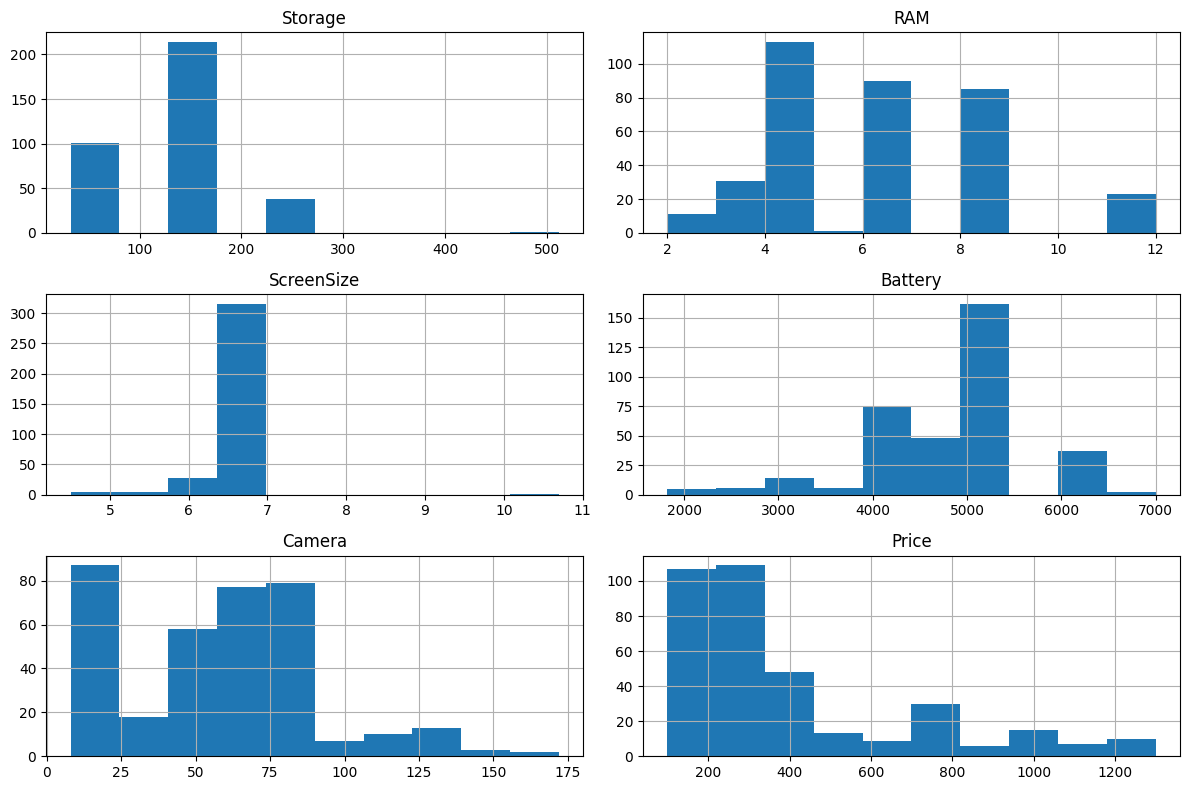

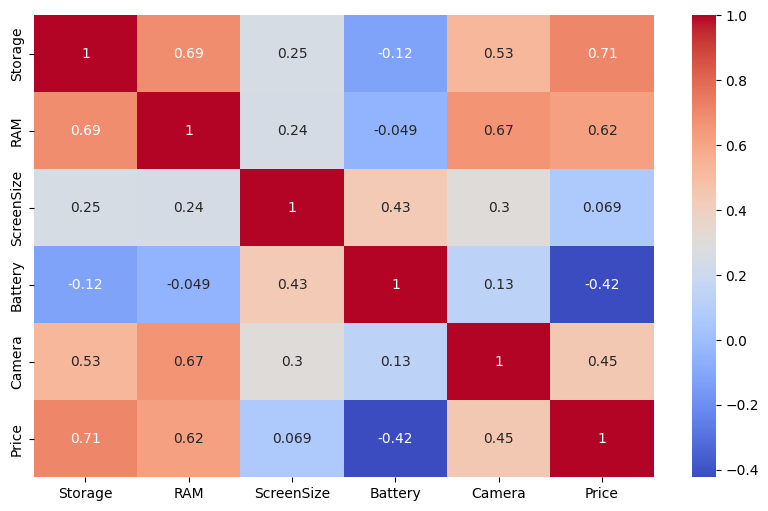

Final shape: (354, 257)


,Storage,RAM,ScreenSize,Battery,Camera,Price,Brand_Asus,Brand_Blackberry,Brand_CAT,Brand_Google,...,Model_iPhone 12 Pro Max,Model_iPhone 12 mini,Model_iPhone 13,Model_iPhone 13 Pro,Model_iPhone 13 Pro Max,Model_iPhone 8 Plus,Model_iPhone SE (2020),Model_iPhone SE (2nd Gen),Model_iPhone XR,Model_iPhone XS Max
0,128,6,6.10,3095,36.0,999,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,256,12,6.80,5000,140.0,1199,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,128,8,6.70,4500,108.0,899,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,128,6,6.67,5020,79.0,279,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,128,8,6.40,4614,172.0,799,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
 import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = load_and_clean_data()

# ======================
# 1. Первичный EDA
# ======================

print("Shape:", df.shape)
print(df.info())
print(df.describe(percentiles=[0.01,0.99]))

# Проверка пропусков
print(df.isna().sum())

# Удаляем полные дубликаты
df = df.drop_duplicates().reset_index(drop=True)

# ======================
# 2. Работа с пропусками
# ======================

# В нашем наборе после очистки их почти нет, но проверим
df = df.fillna(df.median(numeric_only=True))

# ======================
# 3. Поиск аномалий
# ======================

# Аномальные значения Storage/RAM
df = df[df["Storage"].between(8, 1024)]
df = df[df["RAM"].between(1, 32)]

# Аномальные цены (обрезаем 1-й и 99-й перцентиль)
p1, p99 = df["Price"].quantile([0.01, 0.99])
df = df[(df["Price"] >= p1) & (df["Price"] <= p99)]

# ======================
# 4. Числовые распределения
# ======================
numeric_cols = ["Storage","RAM","ScreenSize","Battery","Camera","Price"]

df[numeric_cols].hist(figsize=(12,8))
plt.tight_layout()
plt.show()

# ======================
# 5. Корреляции
# ======================
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.show()

# ======================
# 6. Кодирование категориальных признаков
# ======================

df = pd.get_dummies(df, columns=["Brand","Model"], drop_first=True)

# ======================
# 7. Финальный датасет
# ======================
print("Final shape:", df.shape)
df.head()


Обучите на вашем датасете случайный лес с дефолтными значениями гиперпараметров из `sklearn` и ваш вариант, сделайте сравнение на тесте, запишите выводы.

In [ ]:
y_raw = df_raw["Brand"]

value_counts = y_raw.value_counts()
rare_brands = value_counts[value_counts <= 5].index  # например, <= 5

y_fixed = y_raw.replace(rare_brands, "Other")

# One-Hot Encoding модели (как раньше)
df_raw["Brand_fixed"] = y_fixed

# Создаём новый df без старого Brand, но с Brand_fixed
df2 = df_raw.copy()
df2 = pd.get_dummies(df2, columns=["Brand_fixed", "Model"], drop_first=True)

# Цель — Brand_fixed
brand_cols = [c for c in df2.columns if c.startswith("Brand_fixed_")]
y = df2[brand_cols].idxmax(axis=1).str.replace("Brand_fixed_", "")
X = df2.drop(columns=brand_cols)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # теперь можно, т.к. малых классов нет
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf_sklearn = RandomForestClassifier(random_state=42)
rf_sklearn.fit(X_train, y_train)

y_pred_sklearn = rf_sklearn.predict(X_test)

acc_sklearn = accuracy_score(y_test, y_pred_sklearn)
f1_sklearn = f1_score(y_test, y_pred_sklearn, average="macro")

print("=== Sklearn RandomForest ===")
print(f"Accuracy: {acc_sklearn:.4f}")
print(f"F1-macro: {f1_sklearn:.4f}")

ValueError: could not convert string to float: 'Realme'

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

## <font color='DarkOrange'>**Задача 6 [5 баллов]**</font>

Бустинг - воспользуемся версией catboost.

Таргет и регрессоры выберите по датасету, который использовали в ЛР1,2,3. Решаем задачу классификации.

Сформируйте X_train, X_valid, X_test, y_train, y_valid, y_test - способ выберите сами.


In [ ]:
# Ваш код

In [ ]:
!pip install catboost

Пока не будем настроивать гиперпараметры, проверим как работает "из коробки":

In [ ]:
from catboost import CatBoostClassifier

cl = CatBoostClassifier()
cl.fit(X_train, y_train, verbose=0)

p_valid = cl.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, p_valid)

Попробуем использовать overfitting detector, который реализован в Catboost.

Чтобы все было "честно" разобъем нашу проверочную выборку на две, одну будем использовать для ealy stopping, а вторую для оценки качества:

In [ ]:
from sklearn.model_selection import train_test_split

X_valid1, X_valid2, y_valid1, y_valid2 = train_test_split(
    X_valid, y_valid, test_size=0.5, random_state=42
)

Запускаем обучение с early stopping:

In [ ]:
from catboost import Pool


eval_pool = Pool(X_valid1, y_valid1)
eval_metric = 'AUC'
cl = CatBoostClassifier(eval_metric=eval_metric, random_seed=42)
cl.fit(X_train, y_train,
       eval_set=eval_pool,
       early_stopping_rounds=30,
       use_best_model=True,
       verbose=0)

p_valid2 = cl.predict_proba(X_valid2)[:,1]
roc_auc_score(y_valid2, p_valid2)


In [ ]:
p_train = cl.predict_proba(X_train)[:,1]
roc_auc_score(y_train, p_train)

Стало ли лучше? Повысить качество модели можно с помощью тюнинга гипераметров. Рассмотрим 2 из них - learning_rate и max_depth.

In [ ]:
eval_pool = Pool(X_valid1, y_valid1)
eval_metric = 'AUC'
cl = CatBoostClassifier(learning_rate=0.05,
                        max_depth=8,
                        eval_metric=eval_metric,
                        random_seed=42)
cl.fit(X_train, y_train,
       eval_set=eval_pool,
       early_stopping_rounds=30,
       use_best_model=True,
       verbose=0)

p_valid2 = cl.predict_proba(X_valid2)[:,1]
roc_auc_score(y_valid2, p_valid2)

Удалось ли улучшить метрику в 3-м знаке?

Теперь попробуйте другие значения гипераметров: на этот раз используйте для поиска [Optuna](https://optuna.org/) или [Hyperopt](https://hyperopt.github.io/hyperopt/).


In [ ]:
# Ваш код

### Выбор порога

Построим зависимость точности от полноты:

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score


p, r, t = precision_recall_curve(y_valid2, p_valid2)
plt.plot(r, p)
plt.show()

average_precision_score(y_valid2, p_valid2)

Сравним с "однофичевым" классификатором: выберите тот признак, который, по вашему мнению, самый значимый (пока можно интуитивно выбрать)

In [ ]:
p, r, t = precision_recall_curve(y_valid2, X_valid2.???)
plt.plot(r, p)
plt.show()

average_precision_score(y_valid2, X_valid2.max_p_category_id)

Оценим точность и полноту, при пороге по умолчанию:

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

s_valid2 = cl.predict(X_valid2)

print('precision =', precision_score(y_valid2, s_valid2))
print('recall =', recall_score(y_valid2, s_valid2))
print('F1 =', f1_score(y_valid2, s_valid2))

Оценим возможные значения F1 при других значениях порога:


In [ ]:
p, r, t = precision_recall_curve(y_valid2, p_valid2)
f1 = [2*pi*ri/(pi+ri) for pi, ri, ti in zip(p, r, t)]
plt.plot(t, f1)
plt.show()
max(f1)

Есть ли закономерность: если снизить порог, то можно значительно увеличить F1?

Построим аналогичную кривую для "однофичевого" классификатора:

In [ ]:
p, r, t = precision_recall_curve(y_valid2, X_valid2.???)
f1 = [2*pi*ri/max(1e-14, pi+ri) for pi, ri, ti in zip(p, r, t)]
plt.plot(t, f1)
plt.show()
max(f1)

Все-таки Catboost обгоняет "однофичевый" классификатор :)

### Как сохранить модель

Мы обучили модель, но как ее сохранить, чтобы использовать в другой раз?

In [ ]:
cl.save_model('model.cb')

In [ ]:
!ls -la

In [ ]:
cl2 = CatBoostClassifier()
cl2.load_model('model.cb')

Проверим как работает загруженный классификатор на валидационной выборке:

In [ ]:
roc_auc_score(y_valid2, cl2.predict_proba(X_valid2)[:,1])

Важность признаков:

In [ ]:
sorted(zip(X_train.columns, cl.get_feature_importance()), key=lambda x: -x[1])

Проверим, сохраняется ли важность признаков в файле модели:

In [ ]:
cl2.get_feature_importance()

А названия признаков сохраняются в файле?

In [ ]:
cl2.feature_names_

Количество деревьев в модели:

In [ ]:
cl.tree_count_, cl2.tree_count_

### Конвертация модели

Как использовать модель не из Python или из Python, но без Catboost?

Сохранить в [ONNX](https://ru.wikipedia.org/wiki/ONNX):

In [ ]:
cl.save_model(
    "model.onnx",
    format="onnx",
    export_parameters={
        'onnx_model_version': 1,
        'onnx_doc_string': 'test model for BinaryClassification',
        'onnx_graph_name': 'CatBoostModel_for_BinaryClassification'
    }
)

In [ ]:
!ls -la

In [ ]:
!head -20 model.onnx

Сохранение модели в формате [PMML](https://ru.wikipedia.org/wiki/%D0%AF%D0%B7%D1%8B%D0%BA_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%82%D0%BA%D0%B8_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F):

In [ ]:
cl.save_model(
    "model.pmml",
    format="pmml",
    export_parameters={
        'pmml_description': 'test model for BinaryClassification',
        'pmml_model_version': '1'
    }
)

In [ ]:
!ls -la

PMML - это текстовый файл в формате XML:

In [ ]:
!head -50 model.pmml
!echo "..."
!tail -50 model.pmml

А можем ли конвертировать модель в свой формат или сформировать код функции скоринга на каком-либо языке программирования? Да!

Структура дерева:

In [ ]:
cl.plot_tree(tree_idx=0, pool=X_train)

Как добраться до структуры деревьев программно:
- https://medium.com/@joachimiak.krzysztof/extracting-trees-from-gbm-models-as-data-frames-ce37f4c08ba6

### Как интерпретировать предсказания модели

Как можно объяснить почему модель выдала тот или иной результат? Используем SHAP



In [ ]:
!pip install shap

In [ ]:
import shap

explainer = shap.TreeExplainer(cl)
shap_values = explainer(X_valid2)

Оценим результат прогноза на первом объекте:

In [ ]:
shap.plots.waterfall(shap_values[0])
p_valid2[0]

Оценим результат прогноза на втором объекте:

In [ ]:
shap.plots.waterfall(shap_values[1])
p_valid2[1]

### Что еще стоит знать о Catboost?

### Работа с категориальными признаками

Он поддерживает работу с категориальными (cat) признаками без предварительной обработки, достаточно указать какие именно признаки являются в наборе данных категориальными.


### Обработка пропущенных значений

https://catboost.ai/en/docs/concepts/algorithm-missing-values-processing

Пропущенные значения заменяются на минимальные или максимальные в зависимости от настроек.


---



Рассмотрим реализацию градиентного бустинга над деревьями в других библиотеках.

### Scikit-learn



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

sk_gb_cl = GradientBoostingClassifier()
sk_gb_cl.fit(X_train, y_train)

roc_auc_score(y_valid2, sk_gb_cl.predict_proba(X_valid2)[:,1])

Медленно работает.

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

sk_hgb_cl = HistGradientBoostingClassifier()
sk_hgb_cl.fit(X_train, y_train)

roc_auc_score(y_valid2, sk_hgb_cl.predict_proba(X_valid2)[:,1])

Гораздо быстрее отработал. Ускорение достигается за счет использования гистограмм.

### LightGBM


In [ ]:
import lightgbm

lgbm_cl = lightgbm.LGBMClassifier()
lgbm_cl.fit(X_train, y_train)

roc_auc_score(y_valid2, lgbm_cl.predict_proba(X_valid2)[:,1])

Визуализируем первое дерево модели и рассмотрим отличия от Catboost:

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(40, 40))
lightgbm.plot_tree(lgbm_cl, tree_index=0,dpi=200, ax=ax)
plt.show()

Первое что можно заметить - ветви дерева разные по высоте (глубине).

Поэтому для LightGBM важную роль в обучении модели играет гиперпараметр num_leaves.



### Xgboost

In [ ]:
import xgboost

xgb_cl = xgboost.XGBClassifier()
xgb_cl.fit(X_train, y_train)

roc_auc_score(y_valid2, xgb_cl.predict_proba(X_valid2)[:,1])

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
xgboost.plot_tree(xgb_cl, num_trees=0, rankdir='LR', ax=ax)
plt.show()